# Challenge Overview
Your goal is to generate an undirected network that is as close as possible to the original real network. You do not have the original network in the explicit view, but you know some of its statistics. All statistics are in stats.txt file that contains a dictionary of the form
- number_nodes (number of nodes): value
- number_cc (number of connected components): value, sigma
- radius (radius of giant component): value, sigma
- diameter (diameter of giant component): value, sigma
- average_clustering (average clustering coefficient): value, sigma
- average_path_length (average path length): value, sigma
- degree_cdf (empirical CDF of degree distribution): values, probabilities

Meaning of all these sigmas is described in Evaluation section. 

# Evaluation Criteria

Your total score is calculated as weighted sum of 6 scores — similarities between statistics of original and generated networks. Each score takes values from the interval [0, 1], where 1 — absolute similarity with the original network. The scores are
- "KS"
  + **1 - KS_dist**
  + where **KS_dist** is Kolmogorov-Smirnov distance between degree distributions of real and generated networks
- "Radius"
  + $GK(r, r', \sigma_r) = \exp \left[ -\frac{(r - r')^2}{2 \sigma_r^2} \right]$
  + where **GK** is Gaussian Kernel, **r** is a radius of a gigantic connected component (GCC) of the original network, **r'** is a radius of a generated network, **sigma_r** is a sigma of a radius from stats.txt file
- "Diameter" (GCC), "Av. clustering", "Av. path length" (GCC), "Number of CC" are calculated by Gaussian Kernel in the same way.

- "Total"
1/6 * KS + 1/6 * Radius + 1/6 * Diameter + 1/6 * Av. clustering + 1/6 * Av. path length + 1/6 * Number of CC

All scores immediately take value 0 if a generated network has incorrect number of nodes. All scores are multiplied by 100 on the leaderboard.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import requests
import json
from scipy.stats import ks_2samp
from collections import Counter
from pprint import pprint

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/made-2022/competition_network_generation/stats.txt'
open('stats.txt', 'wb').write(requests.get(url).content)
with open('stats.txt', 'r') as f:
   stats = json.loads(str(f.read()))

In [3]:
pprint(stats)

{'average_clustering': [0.005066798238955518, 0.001],
 'average_path_length': [11.748410823170731, 2],
 'degree_cdf': [[0,
                 1,
                 2,
                 3,
                 4,
                 5,
                 6,
                 7,
                 8,
                 9,
                 10,
                 11,
                 12,
                 13,
                 14,
                 15,
                 16,
                 17,
                 19,
                 21,
                 24,
                 46],
                [0.0,
                 0.6902231668437833,
                 0.8517534537725824,
                 0.9086078639744952,
                 0.9378320935175345,
                 0.9516471838469713,
                 0.9654622741764081,
                 0.9723698193411264,
                 0.9776833156216791,
                 0.9808714133900106,
                 0.9845908607863975,
                 0.9888416578108395,
               

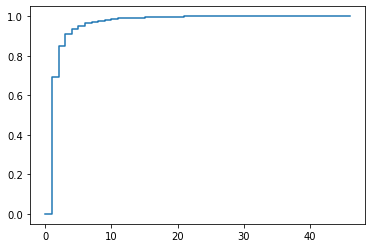

In [4]:
q_seq, p_seq = stats['degree_cdf']
plt.plot(
    np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
    np.repeat(p_seq, 2)
)
plt.show()

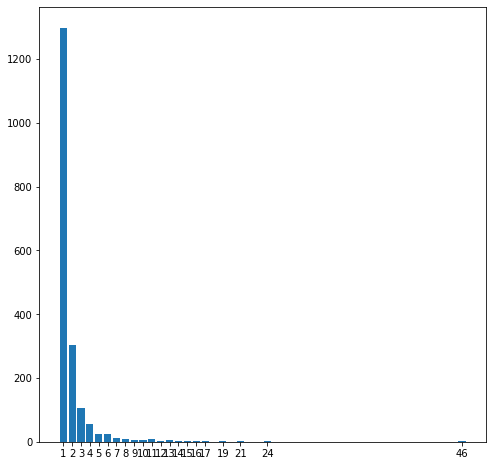

In [5]:
degrees = np.array(np.diff(stats['number_nodes'] * np.array(stats['degree_cdf'][1])), dtype=np.int64)
ind = stats['degree_cdf'][0][1:]
plt.figure(figsize=(8, 8))
plt.bar(ind, degrees)
plt.xticks(ind)
plt.show()

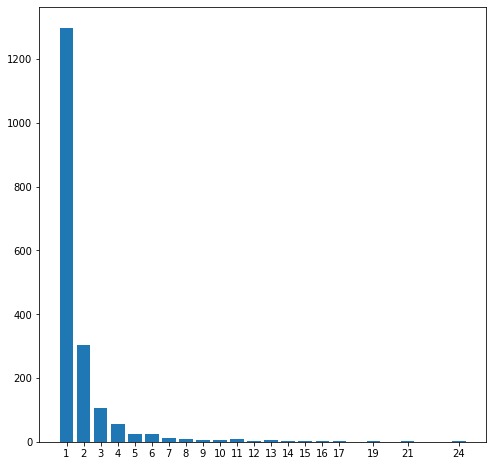

In [6]:
degrees_ = np.array(np.diff(stats['number_nodes'] * np.array(stats['degree_cdf'][1])), dtype=np.int64)[:-1]
ind_ = stats['degree_cdf'][0][1:-1]
plt.figure(figsize=(8, 8))
plt.bar(ind_, degrees_)
plt.xticks(ind_)
plt.show()

Видно, что в графе находится много вершин степени 1, и мало вершин с большой степенью. Можно попробовать это смоделировать "звёздами"

In [7]:
def ks_dist(stats, G):

    cdf_1, cdf_2 = np.zeros(50), np.zeros(50)

    degrees_stats = np.array(np.diff(stats['number_nodes'] * np.array(stats['degree_cdf'][1])), dtype=np.int64)
    ind = stats['degree_cdf'][0][1:]
    degree_seq = [x[1] for x in G.degree]

    for x in zip(stats['degree_cdf'][0][1:], degrees_stats):
        cdf_1[x[0]] = x[1]
    for x in Counter(degree_seq).items():
        cdf_2[x[0]] = x[1]

    return 1 - ks_2samp(cdf_1, cdf_2).statistic

def GK(stats, x):
    return np.exp(-np.square(stats[0] - x) / stats[1] ** 2 / 2)

def score(G):
    GCC = sorted(nx.connected_components(G), key=len)[::-1]
    G_max = G.subgraph(GCC[0])
    ks = ks_dist(stats, G)
    radius = GK(stats['radius'], nx.radius(G_max))
    diameter = GK(stats['diameter'], nx.diameter(G_max))
    avg_cluster = GK(stats['average_clustering'], nx.average_clustering(G))
    avg_path_len = GK(stats['average_path_length'], nx.average_shortest_path_length(G_max))
    num_cc = GK(stats['number_cc'], len(GCC)) 
    print(f'KS: {ks}')
    print(f'Radius: {radius}')
    print(f'Diameter: {diameter}')
    print(f'Avg clustering: {avg_cluster}')
    print(f'Avg Path Len: {avg_path_len}')
    print(f'Num CC: {num_cc}')
    print(f'Sum score: {np.mean([ks, radius, diameter, avg_cluster, avg_path_len, num_cc])}')

Но для начала попробуем baseline, сгенеривовав граф по последовательности степеней вершин

In [8]:
degree_seq = []
for i, d in zip(ind, degrees):
    degree_seq += [i] * d

G = nx.configuration_model(degree_seq)
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

In [9]:
score(G)

KS: 0.96
Radius: 0.04393693362340742
Diameter: 0.04393693362340742
Avg clustering: 0.009500961669425923
Avg Path Len: 0.037978897125959483
Num CC: 4.006529739295107e-05
Sum score: 0.18256563188993222


Score довольно маловат, экспериментируем дальше

Для начала попробуем создать большую компоненту связности, которая удовлетворяет условию на радиус, диаметр и средний путь

Radius: 15, etalon: 15
Diameter: 28, etalon: 28
Av path length: 10.4031007751938, etalon: 11.748410823170731


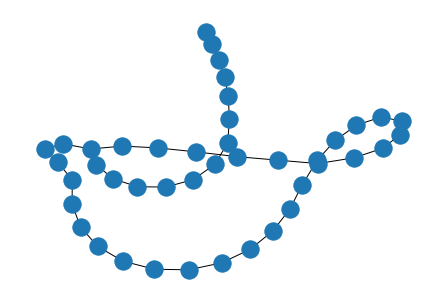

In [10]:
n, m = 30, 43
G = nx.cycle_graph(n)

for i in range(n + 1, m):
    G.add_edge(i - 1, i)

G.add_edge(m - 1, 0)
nx.draw(G)

print(f'Radius: {nx.radius(G)}, etalon: {stats["radius"][0]}')
print(f'Diameter: {nx.diameter(G)}, etalon: {stats["diameter"][0]}')
print(f'Av path length: {nx.average_shortest_path_length(G)}, etalon: {stats["average_path_length"][0]}')

По радиусу и диаметру четкое попадание в яблочко, но хотелось бы улучшить средний путь

Запустим поиск по сетке для поиска параметров, которые генерируют графы с таким же радиусом и диаметром

In [11]:
max_n, max_m = 100, 100

for n in range(1, max_n):
    for m in range(max_m):
        G = nx.cycle_graph(n)

        for i in range(n + 1, m):
            G.add_edge(i - 1, i)

        G.add_edge(m - 1, 0)

        if nx.radius(G) == stats["radius"][0] and nx.diameter(G) == stats["diameter"][0]:
            print(f'n = {n}, m = {m}')

n = 30, m = 43
n = 31, m = 44
n = 56, m = 27
n = 56, m = 28
n = 56, m = 30
n = 56, m = 31
n = 57, m = 28
n = 57, m = 29
n = 57, m = 30
n = 57, m = 31


Забыл ввести ограничение на то, что $m < n$, но эта ошибка привела к лучшему результату)

Radius: 15, etalon: 15
Diameter: 28, etalon: 28
Av path length: 11.25, etalon: 11.748410823170731


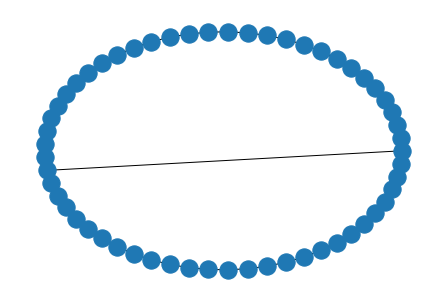

In [12]:
n, m = 57, 31
G = nx.cycle_graph(n)

#for i in range(n + 1, m):
#    G.add_edge(i - 1, i)

G.add_edge(m - 1, 0)
nx.draw_circular(G)
nx.set_node_attributes(G, "GCC", name="type")

print(f'Radius: {nx.radius(G)}, etalon: {stats["radius"][0]}')
print(f'Diameter: {nx.diameter(G)}, etalon: {stats["diameter"][0]}')
print(f'Av path length: {nx.average_shortest_path_length(G)}, etalon: {stats["average_path_length"][0]}')

Получается, что вот такой цикличный граф с одной проведенной "хордой" довольно хорошо подходит под самую большую компоненту связности нашего графа.

Запомним, что теперь мы не должны генерировать компоненты связности с числом вершим > 57

Добавим в граф звёзды, чтобы полностью описать степени большие 4 (ограничение на размер компоненты связности выполняется, т.к. самая большая звезда будет генерироваться на 46 вершинах)

In [13]:
for deg, num_stars in zip(ind[4:], degrees[4:]):
    for _ in range(num_stars):
        G1 = nx.star_graph(deg)
        nx.set_node_attributes(G1, "star", name="type")
        G = nx.disjoint_union(G, G1)

Введем вспомогательную функцию для сравнения характеристик

In [14]:
def diff_stats(G, stats=stats):
    print('Number nodes:')
    G_nodes = len(G)
    stats_nodes = stats["number_nodes"]
    diff_nodes = stats_nodes - G_nodes
    print(f'G: {G_nodes}, stats: {stats_nodes}, diff: {diff_nodes}')

    print('Number connected components:')
    G_cc = nx.number_connected_components(G)
    stats_cc = stats["number_cc"][0]
    diff_cc = stats_cc - G_cc
    print(f'G: {G_cc}, stats: {stats_cc}, diff: {diff_cc}')

    print('Degree cdf:')
    degrees_stats = np.array(np.diff(stats_nodes * np.array(stats['degree_cdf'][1])), dtype=np.int64)
    ind = stats['degree_cdf'][0][1:]
    degree_seq = [x[1] for x in G.degree]
    degrees_G = []
    for x in ind:
        degrees_G.append(degree_seq.count(x))
    print('x \t d_stats \t d_G \t diff')
    for x, d_stats, d_G in zip(ind, degrees_stats, degrees_G):
        print(f'{x} \t {d_stats} \t\t {d_G} \t {d_stats - d_G}')

    print(f'Length of max connected component: {len(max(nx.connected_components(G), key=len))}')

In [15]:
diff_stats(G)

Number nodes:
G: 1206, stats: 1882, diff: 676
Number connected components:
G: 118, stats: 168, diff: 50
Degree cdf:
x 	 d_stats 	 d_G 	 diff
1 	 1299 		 1032 	 267
2 	 304 		 55 	 249
3 	 107 		 2 	 105
4 	 55 		 0 	 55
5 	 26 		 26 	 0
6 	 26 		 26 	 0
7 	 13 		 13 	 0
8 	 10 		 10 	 0
9 	 6 		 6 	 0
10 	 7 		 7 	 0
11 	 8 		 8 	 0
12 	 1 		 1 	 0
13 	 6 		 6 	 0
14 	 2 		 2 	 0
15 	 3 		 3 	 0
16 	 1 		 1 	 0
17 	 2 		 2 	 0
19 	 2 		 2 	 0
21 	 2 		 2 	 0
24 	 1 		 1 	 0
46 	 1 		 1 	 0
Length of max connected component: 57


Добавим 4-регулярный граф на 55 вершинах, чтобы покрыть в распределении вершин степень равную 4

In [16]:
seed = 42

In [17]:
G1 = nx.random_regular_graph(4, 55, seed=seed)
nx.set_node_attributes(G1, "4-regular", name="type")
G = nx.disjoint_union(G, G1)

In [18]:
diff_stats(G)

Number nodes:
G: 1261, stats: 1882, diff: 621
Number connected components:
G: 119, stats: 168, diff: 49
Degree cdf:
x 	 d_stats 	 d_G 	 diff
1 	 1299 		 1032 	 267
2 	 304 		 55 	 249
3 	 107 		 2 	 105
4 	 55 		 55 	 0
5 	 26 		 26 	 0
6 	 26 		 26 	 0
7 	 13 		 13 	 0
8 	 10 		 10 	 0
9 	 6 		 6 	 0
10 	 7 		 7 	 0
11 	 8 		 8 	 0
12 	 1 		 1 	 0
13 	 6 		 6 	 0
14 	 2 		 2 	 0
15 	 3 		 3 	 0
16 	 1 		 1 	 0
17 	 2 		 2 	 0
19 	 2 		 2 	 0
21 	 2 		 2 	 0
24 	 1 		 1 	 0
46 	 1 		 1 	 0
Length of max connected component: 57


Повторим примерно тоже самое для степени 3, но добавим несколько графов, чтобы увеличивалось количество компонент связности. Также регулярным графом не выйдет покрыть все вершины степени 3, т.к. $n \cdot d$ нечётно 

In [19]:
for _ in range(5):
    G1 = nx.random_regular_graph(3, 20, seed=seed)
    nx.set_node_attributes(G1, "3-regular", name="type")
    G = nx.disjoint_union(G, G1)

In [20]:
diff_stats(G)

Number nodes:
G: 1361, stats: 1882, diff: 521
Number connected components:
G: 124, stats: 168, diff: 44
Degree cdf:
x 	 d_stats 	 d_G 	 diff
1 	 1299 		 1032 	 267
2 	 304 		 55 	 249
3 	 107 		 102 	 5
4 	 55 		 55 	 0
5 	 26 		 26 	 0
6 	 26 		 26 	 0
7 	 13 		 13 	 0
8 	 10 		 10 	 0
9 	 6 		 6 	 0
10 	 7 		 7 	 0
11 	 8 		 8 	 0
12 	 1 		 1 	 0
13 	 6 		 6 	 0
14 	 2 		 2 	 0
15 	 3 		 3 	 0
16 	 1 		 1 	 0
17 	 2 		 2 	 0
19 	 2 		 2 	 0
21 	 2 		 2 	 0
24 	 1 		 1 	 0
46 	 1 		 1 	 0
Length of max connected component: 57


Повторим для степени два (в целом, это значит что надо добавлять циклические графы)

In [21]:
for _ in range(25):
    G1 = nx.cycle_graph(10)
    nx.set_node_attributes(G1, "cycle", name="type")
    G = nx.disjoint_union(G, G1)

In [22]:
diff_stats(G)

Number nodes:
G: 1611, stats: 1882, diff: 271
Number connected components:
G: 149, stats: 168, diff: 19
Degree cdf:
x 	 d_stats 	 d_G 	 diff
1 	 1299 		 1032 	 267
2 	 304 		 305 	 -1
3 	 107 		 102 	 5
4 	 55 		 55 	 0
5 	 26 		 26 	 0
6 	 26 		 26 	 0
7 	 13 		 13 	 0
8 	 10 		 10 	 0
9 	 6 		 6 	 0
10 	 7 		 7 	 0
11 	 8 		 8 	 0
12 	 1 		 1 	 0
13 	 6 		 6 	 0
14 	 2 		 2 	 0
15 	 3 		 3 	 0
16 	 1 		 1 	 0
17 	 2 		 2 	 0
19 	 2 		 2 	 0
21 	 2 		 2 	 0
24 	 1 		 1 	 0
46 	 1 		 1 	 0
Length of max connected component: 57


Аккуратно добавим звёзд, чтобы:
- максимально покрыть степени равные 1 (при этом слегка попортится статистика на больших степенях)
- покрыть необходимое число вершин
- покрыть необходимое число компонент связности

In [23]:
for _ in range(18):
    G1 = nx.star_graph(13)
    nx.set_node_attributes(G1, "star", name="type")
    G = nx.disjoint_union(G, G1)

In [24]:
diff_stats(G)

Number nodes:
G: 1863, stats: 1882, diff: 19
Number connected components:
G: 167, stats: 168, diff: 1
Degree cdf:
x 	 d_stats 	 d_G 	 diff
1 	 1299 		 1266 	 33
2 	 304 		 305 	 -1
3 	 107 		 102 	 5
4 	 55 		 55 	 0
5 	 26 		 26 	 0
6 	 26 		 26 	 0
7 	 13 		 13 	 0
8 	 10 		 10 	 0
9 	 6 		 6 	 0
10 	 7 		 7 	 0
11 	 8 		 8 	 0
12 	 1 		 1 	 0
13 	 6 		 24 	 -18
14 	 2 		 2 	 0
15 	 3 		 3 	 0
16 	 1 		 1 	 0
17 	 2 		 2 	 0
19 	 2 		 2 	 0
21 	 2 		 2 	 0
24 	 1 		 1 	 0
46 	 1 		 1 	 0
Length of max connected component: 57


In [25]:
G1 = nx.star_graph(18)
nx.set_node_attributes(G1, "star", name="type")
G = nx.disjoint_union(G, G1)

In [26]:
diff_stats(G)

Number nodes:
G: 1882, stats: 1882, diff: 0
Number connected components:
G: 168, stats: 168, diff: 0
Degree cdf:
x 	 d_stats 	 d_G 	 diff
1 	 1299 		 1284 	 15
2 	 304 		 305 	 -1
3 	 107 		 102 	 5
4 	 55 		 55 	 0
5 	 26 		 26 	 0
6 	 26 		 26 	 0
7 	 13 		 13 	 0
8 	 10 		 10 	 0
9 	 6 		 6 	 0
10 	 7 		 7 	 0
11 	 8 		 8 	 0
12 	 1 		 1 	 0
13 	 6 		 24 	 -18
14 	 2 		 2 	 0
15 	 3 		 3 	 0
16 	 1 		 1 	 0
17 	 2 		 2 	 0
19 	 2 		 2 	 0
21 	 2 		 2 	 0
24 	 1 		 1 	 0
46 	 1 		 1 	 0
Length of max connected component: 57


In [27]:
score(G)

KS: 0.98
Radius: 1.0
Diameter: 1.0
Avg clustering: 0.10877146241653772
Avg Path Len: 0.9694254829422113
Num CC: 1.0
Sum score: 0.8430328242264582


Этим способом удалось добиться $score=84\%$

Ниже представлен полный пайплайн

In [28]:
seed = 42
degrees = np.array(np.diff(stats['number_nodes'] * np.array(stats['degree_cdf'][1])), dtype=np.int64)
ind = stats['degree_cdf'][0][1:]

n, m = 57, 31
G = nx.cycle_graph(n)
G.add_edge(m - 1, 0)
nx.set_node_attributes(G, "GCC", name="type")

for deg, num_stars in zip(ind[4:], degrees[4:]):
    for _ in range(num_stars):
        G1 = nx.star_graph(deg)
        nx.set_node_attributes(G1, "star", name="type")
        G = nx.disjoint_union(G, G1)

G1 = nx.random_regular_graph(4, 55, seed=seed)
nx.set_node_attributes(G1, "4-regular", name="type")
G = nx.disjoint_union(G, G1)

for _ in range(5):
    G1 = nx.random_regular_graph(3, 20, seed=seed)
    nx.set_node_attributes(G1, "3-regular", name="type")
    G = nx.disjoint_union(G, G1)

for _ in range(25):
    G1 = nx.cycle_graph(10)
    nx.set_node_attributes(G1, "cycle", name="type")
    G = nx.disjoint_union(G, G1)

for _ in range(18):
    G1 = nx.star_graph(13)
    nx.set_node_attributes(G1, "star", name="type")
    G = nx.disjoint_union(G, G1)

G1 = nx.star_graph(18)
nx.set_node_attributes(G1, "star", name="type")
G = nx.disjoint_union(G, G1)

In [29]:
score(G)

KS: 0.98
Radius: 1.0
Diameter: 1.0
Avg clustering: 0.10877146241653772
Avg Path Len: 0.9694254829422113
Num CC: 1.0
Sum score: 0.8430328242264582


Нарисуем получившийся граф

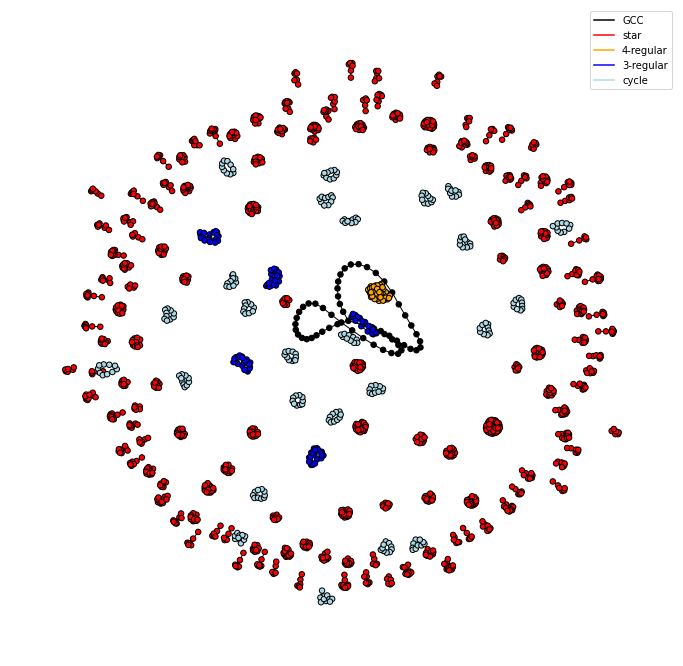

In [30]:
colors = {
    "GCC": 'black',
    "star": 'red',
    "4-regular": 'orange',
    "3-regular": 'blue',
    "cycle": 'lightblue'
}

color_attr = {node: colors[t] for node, t in nx.get_node_attributes(G, 'type').items()}
nx.set_node_attributes(G, color_attr, 'color')
node_color = list(nx.get_node_attributes(G, 'color').values())

f = plt.figure(figsize=(12, 12))
ax = f.add_subplot(1, 1, 1)
for label, color in colors.items():
    ax.plot([0], [0], color=color, label=label)

nx.draw(G,
        node_size=30,
        pos=nx.spring_layout(G, k=2e-2),
        node_color=node_color,
        edgecolors='black',
        linewidths=1)

plt.legend();

Сохраним этот граф в файл

In [31]:
nx.write_edgelist(G, 'submit.txt', data=False)